# AprilTag Minimal Working Example with Dedicated Hardware 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AccelerationConsortium/ac-training-lab/blob/main/src/ac_training_lab/apriltag_hardware_demo/apriltag_hardware_demo.ipynb)


## Introduction 

### What this system does

This system uses a rotating turntable, AprilTag visual markers, and a MyCobot robotic arm to identify, localize, and manipulate vials. The robot can automatically pick up or place vials at specified positions on the turntable.

### Why AprilTags are used

AprilTags provide robust and accurate visual markers that enable the system to detect specific positions on the turntable. Since tags are attached to the turntable (not the vials), they help determine the vial’s location indirectly through a mapping. This allows the system to precisely stop the turntable at the right spot for pick-and-place operations.

### How the workflow proceeds in steps
1. After startup, the turntable rotates slowly.
2. A fixed camera captures frames continuously to detect AprilTags.
3. When the target tag is found, the turntable stops and the corresponding vial is aligned for interaction.
4. The tag’s position is recalculated and converted into robot coordinates using a pre-calibrated transformation matrix.
5. The robot arm grabs or places the vial from the side.

## Configuration

To explore the demo with default files and settings, enable test mode below. If test mode is enabled, you can skip all parameter modifications in this demo.

In [7]:
# @markdown Set `test = True` to use default files and parameters.
test = True  # @param {type:"boolean"}

## Requirements

This notebook requires the following files and libraries. 

In [1]:
# only install if we are running in colab
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    %pip install --upgrade gradio_client

## Live Stream

##### Watch the live demo here: https://www.youtube.com/playlist?list=PL8uZlc2CEpelrYXunUzUOMJC17wEhiP6Q

This live stream shows the dedicated hardware in action, giving you a real-time view of what’s happening in the lab.
You’ll see the AprilTags, turntable, and cobot working together to complete the workflow.
As you run the notebook, each step is mirrored by real-world motion.

> Tips: For a smoother experience, use Picture-in-Picture mode to keep the live stream visible while interacting with the notebook (right-click the video twice in Google Chrome or Microsoft Edge), or consider using split screen to view the notebook and stream side by side.


## Static configuration

Predefined system parameters, determined by the hardware setup and relative positioning.

#### **⚠ Do not modify any of them.**


### Tracking vials in turntable
To track each specific vial and its current position, as well as whether a turntable position is occupied, we maintain two bidirectional mappings in the program:

- Turntable ID ↔ AprilTag ID
- Turntable ID ↔ Vial ID

This allows the program to identify the corresponding AprilTag and vial for each position, so users can assign a specific vial to a specific slot.

> Note:  You can refer to the livestream to visually confirm the mapping. The key in the vial_to_turntable dictionary is the vial ID, and the value is the turntable position ID.


In [151]:
# Static configuration
# Only positions currently occupied by vials
vial_to_turntable = {
    'vial_1': 3, # vial_1 is currently placed at turntable position 3
    'vial_2': 1,
    'vial_3': 5,
}

# All turntable positions and their associated AprilTags
turntable_to_tag = {
    1: 'tag_01', # turntable position 1 is labeled by tag_01
    2: 'tag_02',
    3: 'tag_03',
    4: 'tag_04',
    5: 'tag_05',
    6: 'tag_06',
    7: 'tag_07',
    8: 'tag_08',
    
}

# Generate reverse mappings
tag_to_turntable = {v: k for k, v in turntable_to_tag.items()}
turntable_to_vial = {v: k for k, v in vial_to_turntable.items()}

### Camera Intrinsics

Camera intrinsics obtained from camera calibration, including camera matrix and distortion coefficients. Used for AprilTag detection and pose estimation.

In [1]:
# @title Load Camera Calibration (DO NOT MODIFY)
import os
import numpy as np

current_dir = os.getcwd()  # already in apriltag_hardware_demo/
camera_params_path = os.path.join(current_dir, "camera_params.npy")

camera_params = np.load(camera_params_path, allow_pickle=True).item()
K = camera_params["camera_matrix"]
dist = camera_params["dist_coeff"]

camera_intrinsics = (K, dist)
print(camera_intrinsics)

(array([[500.54702464,   0.        , 322.2119361 ],
       [  0.        , 500.40255263, 233.49655315],
       [  0.        ,   0.        ,   1.        ]]), array([[ 0.0715937 , -0.11035395, -0.00074593,  0.00080148, -0.03623521]]))



### Hand-Eye Calibration Result

Camera intrinsics obtained from camera calibration, including camera matrix and distortion coefficients. Used for predicting vial positions and performing grasping.

In [ ]:
# @title Load Hand-Eye Calibration (DO NOT MODIFY)
import os
import numpy as np

# Assume current working directory is apriltag_hardware_demo
current_dir = os.getcwd()
hand_eye_path = os.path.join(current_dir, "hand_eye_calibration.npy")

hand_eye_params = np.load(hand_eye_path, allow_pickle=True).item()
rotation_matrix = hand_eye_params["rotation_matrix"]
translation_vector = hand_eye_params["translation_vector"].flatten() * 1000 

hand_eye_calibration = (rotation_matrix, translation_vector)

print(hand_eye_calibration)

rotation_matrix = np.eye(3)  
translation_vector = np.zeros(3)  

(array([[ 0.99911483,  0.04183356, -0.00441625],
       [-0.04177353,  0.99904373,  0.01290723],
       [ 0.00495198, -0.01271132,  0.99990695]]), array([-45.79850956,   2.55546143,  11.34985024]))


### Default Positions

- **Initial Home Pose**: Moves the cobot to all-zero joint angles as the home or reset position.
- **Default Detection Pose**: Moves the cobot to a pre-defined joint configuration for AprilTag detection.

In [ ]:
# @title Default Detection Pose and Initial Home Pose Configuration (DO NOT MODIFY)

INITIAL_HOME_POSE = {
    "angle0": 0,
    "angle1": 0,
    "angle2": 0,
    "angle3": 0,
    "angle4": 0,
    "angle5": 0,
    "movement_speed": 50
}

DEFAULT_DETECTION_POSE = {
    "angle0": 124.01,
    "angle1": -28.91,
    "angle2": -136.14,
    "angle3": 123.66,
    "angle4": -88.94,
    "angle5": 36.91,
    "movement_speed": 50
}

DEFAULT_DETECTION_COORDS = {
    "x": 18.0,
    "y": 168.0,
    "z": 197.4,
    "rx": -90.76,
    "ry": -5.17,
    "rz": -55.06,
    "movement_speed": 50
}

### Grasp Offset

Fixed offset from the AprilTag center to the vial position behind it, defined in the tag's coordinate frame.

In [ ]:
# @title Grasp Offset Configuration (DO NOT MODIFY)

GRIPPER_TOTAL_OFFSET = np.array([
    0.0,  
     20.0,  
    -80.0
])  



## Helper functions

### `detect_apriltags`
This is a helper function for detecting AprilTags.
- When `only_ID=True`, it returns only the tag IDs, which is useful for identifying the correct AprilTag while the turntable is rotating.
- When `only_ID=False`, it returns both the position and orientation of each tag, which is used by the cobot to place or pick up a vial after the turntable has stopped.

In [7]:
import cv2
import numpy as np
from pupil_apriltags import Detector
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

def detect_apriltags(image_path, camera_matrix, dist_coeffs, tag_size_meters, families="tagStandard41h12", only_ID=True, show_image=False):
    """
    AprilTag detection function with built-in undistortion.
    """
    # Load grayscale image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    if image is None:
        raise ValueError(f"Failed to load image at {image_path}")

    # Undistort image first
    undistorted_image = cv2.undistort(image, camera_matrix, dist_coeffs)

    # Extract fx, fy, cx, cy for pupil_apriltags input
    fx, fy = camera_matrix[0,0], camera_matrix[1,1]
    cx, cy = camera_matrix[0,2], camera_matrix[1,2]
    pupil_camera_params = [fx, fy, cx, cy]

    # Initialize detector
    at_detector = Detector(
        families=families,
        nthreads=1,
        quad_decimate=1.0,
        quad_sigma=0.0,
        refine_edges=1,
        decode_sharpening=0.25,
        debug=0
    )

    detections = at_detector.detect(
        undistorted_image,
        estimate_tag_pose=True,
        camera_params=pupil_camera_params,
        tag_size=tag_size_meters
    )

    if only_ID:
        return [det.tag_id for det in detections]

    print(f"Found {len(detections)} tags")
    for det in detections:
        tag_id = det.tag_id
        center = det.center
        corners = det.corners.astype(int)

        cv2.polylines(undistorted_image, [corners], True, 255, 2)
        cx, cy = map(int, center)
        cv2.circle(undistorted_image, (cx, cy), 4, 255, -1)
        cv2.putText(undistorted_image, str(tag_id), (cx, cy - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 255, 1)

        print(f"\nTag ID: {tag_id}")
        print(f"  Center: {center}")
        print(f"  Corners: {det.corners}")

        if det.pose_t is not None:
            t = det.pose_t.flatten()
            print(f"  Translation (x, y, z): {t}")

            distance_cm = np.linalg.norm(t) * 100
            print(f"  Distance from camera: {distance_cm:.2f} centimeters")

            euler = R.from_matrix(det.pose_R).as_euler('xyz', degrees=True)
            roll, pitch, yaw = euler
            print(f"  Roll: {roll:.2f}°, Pitch: {pitch:.2f}°, Yaw: {yaw:.2f}°")
        else:
            print("  No pose estimated (pose_t is None)")

    if show_image:
        plt.imshow(undistorted_image, cmap='gray')
        plt.title("AprilTag Detection (Undistorted)")
        plt.show()

    return detections



### `display_image` and `display_result`

- `display_image(image_path)`: Displays the image at the given path (used to check camera view or results).
- `display_result(result)`: Parses and prints server response, shows queue status and detection results, and displays image if available.

In [8]:
import matplotlib.pyplot as plt
from PIL import Image
import json

def display_image(image_path):
	try:
		img = Image.open(image_path).convert("RGB")
		plt.imshow(img)
		plt.title("Cobot view")
		plt.show()
	except Exception as e:
		print(f"An error occurred: {e}")

def display_result(result):
	queue_status_str = result[-1].replace('\n', ' ')
	print(f"queue status: {queue_status_str}")
	print(f"response json: {None if result[0] is None else json.loads(result[0])}")
	if len(result) == 3:
		if result[1] is None:
			return
		display_image(result[1]['value'])

### `decompose_transform` and `convert`

- `decompose_transform(matrix)`: Decomposes a 4x4 homogeneous transformation matrix into translation and Euler angles (rx, ry, rz). Used to extract position and orientation from computed poses.
- `convert(x, y, z, rx, ry, rz, x1, y1, z1, rx1, ry1, rz1, hand_eye_calibration)`: Computes the object pose in the robot base frame by chaining the robot's end-effector pose, the detected object pose from camera, and the hand-eye calibration result.

In [9]:
from scipy.spatial.transform import Rotation as R
import numpy as np


import numpy as np
from scipy.spatial.transform import Rotation as R


def decompose_transform(matrix):

    translation = matrix[:3, 3]
    rotation = matrix[:3, :3]

    # Convert rotation matrix to euler angles (rx, ry, rz)
    sy = np.sqrt(rotation[0, 0] * rotation[0, 0] + rotation[1, 0] * rotation[1, 0])
    singular = sy < 1e-6

    if not singular:
        rx = np.arctan2(rotation[2, 1], rotation[2, 2])
        ry = np.arctan2(-rotation[2, 0], sy)
        rz = np.arctan2(rotation[1, 0], rotation[0, 0])
    else:
        rx = np.arctan2(-rotation[1, 2], rotation[1, 1])
        ry = np.arctan2(-rotation[2, 0], sy)
        rz = 0

    return translation, rx, ry, rz


def convert(x,y,z,rx,ry,rz,x1,y1,z1,rx1,ry1,rz1):

    obj_camera_coordinates = np.array([x1, y1, z1,rx1,ry1,rz1])

    end_effector_pose = np.array([x, y, z,
                                  rx, ry, rz])
    
    T_camera_to_end_effector = np.eye(4)
    T_camera_to_end_effector[:3, :3] = rotation_matrix
    T_camera_to_end_effector[:3, 3] = translation_vector

    position = end_effector_pose[:3]
    orientation = R.from_euler('xyz', end_effector_pose[3:], degrees=False).as_matrix()

    T_end_to_base_effector = np.eye(4)
    T_end_to_base_effector[:3, :3] = orientation
    T_end_to_base_effector[:3, 3] = position

    position2 = obj_camera_coordinates[:3]
    orientation2 = R.from_euler('xyz', obj_camera_coordinates[3:], degrees=False).as_matrix()

    T_object_to_camera_effector = np.eye(4)
    T_object_to_camera_effector[:3, :3] = orientation2
    T_object_to_camera_effector[:3, 3] = position2


    obj_end_effector_coordinates_homo = T_camera_to_end_effector.dot(T_object_to_camera_effector)

    obj_base_effector = T_end_to_base_effector.dot(obj_end_effector_coordinates_homo)

    result = decompose_transform(obj_base_effector)

    return result


### `move_to_pose`

- Used to move the robot directly to the computed grasping position.

In [10]:
def move_to_pose(result_pose, movement_speed=50):
    position, rx, ry, rz = result_pose

    x_mm, y_mm, z_mm = [round(float(val), 2) for val in position]
    roll_deg = round(np.degrees(rx), 2)
    pitch_deg = round(np.degrees(ry), 2)
    yaw_deg = round(np.degrees(rz), 2)

    print("Sending coords (mm, deg):", x_mm, y_mm, z_mm, roll_deg, pitch_deg, yaw_deg)

    result = client.predict(
        user_id=USER_ID,
        x=x_mm,
        y=y_mm,
        z=z_mm,
        roll=roll_deg,
        pitch=pitch_deg,
        yaw=yaw_deg,
        movement_speed=movement_speed,
        api_name="/control_coords"
    )
    display_result(result)



In [12]:
import time
import json

def lock_cobot_position(client, user_id, speed=10):
    """
    Queries current cobot joint angles and sends them back to lock the position.

    Parameters:
    - client: your gradio client
    - user_id: ID for the prediction queue
    - speed: speed for send_angles (default: 10)
    """
    # Step 1: query current joint angles
    raw_result = client.predict(
        user_id=user_id,
        api_name="/query_angles"
    )

    print("Raw response:", raw_result)

    try:
        result = json.loads(raw_result[0])
    except Exception as e:
        print("Failed to parse JSON response:", e)
        return

    if "angles" not in result:
        print("Failed to get angles from cobot.")
        return

    angles = result["angles"]
    print("Queried current angles:", angles)

    # Step 2: convert to expected named params
    payload = {
        f"angle{i}": angle for i, angle in enumerate(angles)
    }
    payload["movement_speed"] = speed

    # Step 3: send angles to lock position
    try:
        response = client.predict(
            user_id=user_id,
            **payload,
            api_name="/control_angles"
        )
        print("Sent angles to lock position.")
        print("Server response:", response)
    except Exception as e:
        print("Failed to send angles:", e)

## Connecting to the Cobot

### Initialize Gradio Client

- Create a unique `USER_ID` for the current session.
- Connect to the remote Gradio server (`cobot280pi-gradio-g9sv`) using Hugging Face token.
- `client.view_api()` lists available API endpoints for interaction.

In [13]:
from gradio_client import Client
import uuid
import getpass  

USER_ID = str(uuid.uuid4())
print(f"Your user id: {USER_ID}")

hf_token = getpass.getpass("Enter your Hugging Face Token:")

client = Client(
    "AccelerationConsortium/cobot280pi-gradio-g9sv",
    hf_token=hf_token
)

client.view_api()

result = client.predict(
    user_id=USER_ID,
    api_name="/enter_queue"
)

print(result)


Your user id: 9a362e8c-3136-410b-9e67-8a8f7053373a
Loaded as API: https://accelerationconsortium-cobot280pi-gradio-g9sv.hf.space ✔
Client.predict() Usage Info
---------------------------
Named API endpoints: 15

 - predict(user_id, api_name="/query_angles") -> (response, queue_status)
    Parameters:
     - [Textbox] user_id: str (required)  
    Returns:
     - [Textbox] response: str 
     - [Textbox] queue_status: str 

 - predict(user_id, api_name="/query_coords") -> (response, queue_status)
    Parameters:
     - [Textbox] user_id: str (required)  
    Returns:
     - [Textbox] response: str 
     - [Textbox] queue_status: str 

 - predict(user_id, api_name="/query_gripper") -> (response, queue_status)
    Parameters:
     - [Textbox] user_id: str (required)  
    Returns:
     - [Textbox] response: str 
     - [Textbox] queue_status: str 

 - predict(user_id, api_name="/query_camera") -> (response, value_72, queue_status)
    Parameters:
     - [Textbox] user_id: str (required)  

### Enter Queue

- Call `/enter_queue` API to join the task queue.
- The server assigns a queue position and returns status info.

In [14]:
result = client.predict(
    user_id=USER_ID,
    api_name="/enter_queue"
)

print(result)

Your turn!
Time remaining: 112.54 seconds.


## Cobot Vial Pick-and-Place Workflow

First, move the cobot to the default place to detect apriltag

In [1413]:
result = client.predict(
    user_id=USER_ID,
    **DEFAULT_DETECTION_POSE, 
    api_name="/control_angles"
)
display_result(result)

queue status: Your turn! Time remaining: 3.00 seconds.
response json: {'success': True, 'command': 'control/angles'}


In [1027]:
result = client.predict(
	user_id=USER_ID,
	api_name="/query_coords"
)
display_result(result)

queue status: Your turn! Time remaining: 63.07 seconds.
response json: {'success': True, 'coords': [18.9, 168.5, 196.0, -90.48, -5.71, -55.86], 'command': 'query/coords'}


Then detect the AprilTag. If no tag is detected, retry several times.

('{\n    "success": true,\n    "command": "query/camera"\n}', {'visible': True, 'value': 'C:\\Users\\86173\\AppData\\Local\\Temp\\gradio\\ca22a04e26b8a23f9e9ce1157b82d9c64baedb8b37ada281b4f8cb1497857e1d\\image.webp', '__type__': 'update'}, 'Your turn!\nTime remaining: 80.64 seconds.')
queue status: Your turn! Time remaining: 80.64 seconds.
response json: {'success': True, 'command': 'query/camera'}


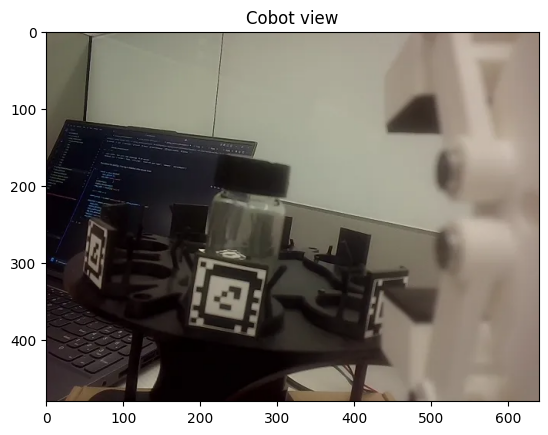

Found 2 tags

Tag ID: 1
  Center: [193.5937007   64.77685779]
  Corners: [[178.79005432  56.39551544]
 [166.73664856  68.9577713 ]
 [209.25312805  73.64271545]
 [219.03762817  60.81592941]]
  Translation (x, y, z): [-0.04030077 -0.05291438  0.15690369]
  Distance from camera: 17.04 centimeters
  Roll: -0.93°, Pitch: 54.37°, Yaw: 95.35°

Tag ID: 2
  Center: [135.13726996 234.94914936]
  Corners: [[115.83260345 205.99633789]
 [106.36696625 255.39717102]
 [154.91894531 264.61737061]
 [164.33096313 214.20021057]]
  Translation (x, y, z): [-0.04787424  0.00038393  0.12819274]
  Distance from camera: 13.68 centimeters
  Roll: 4.20°, Pitch: 1.87°, Yaw: 100.02°


In [1445]:
result = client.predict(
	user_id=USER_ID,
	api_name="/query_camera"
)
print(result)
display_result(result)
image_path = result[1]["value"]

import numpy as np

camera_params = np.load("camera_params.npy", allow_pickle=True).item()

detections = detect_apriltags(
    image_path,
    camera_matrix=camera_params['camera_matrix'],
    dist_coeffs=camera_params['dist_coeff'],
    tag_size_meters=0.013,
    families="tagStandard52h13",
    only_ID=False
)


In [ ]:
det = min(detections, key=lambda d: np.linalg.norm(d.pose_t))

pose_t = det.pose_t.flatten()         
pose_R = det.pose_R                  

GRIPPER_TOTAL_OFFSET = np.array([0.0, 20.0, -80.0])  

offset_in_world = pose_R @ (GRIPPER_TOTAL_OFFSET / 1000.0)  
pose_t_corrected = pose_t + offset_in_world               
pose_t_corrected_mm = pose_t_corrected * 1000             

rx1, ry1, rz1 = R.from_matrix(pose_R).as_euler('xyz', degrees=False)  

x1, y1, z1 = pose_t_corrected_mm

print("Corrected position for gripper (mm):", pose_t_corrected_mm)
print("Euler angles (radians):", rx1, ry1, rz1)
print("Tag Z axis in camera frame:", pose_R[:, 2])

Corrected position for gripper (mm): [-72.83848714  -6.62962502  49.91377729]
Euler angles (radians): 0.07328596084275116 0.03270832255663536 1.7457448286513364
Tag Z axis in camera frame: [0.06642587 0.04486141 0.99678235]


In [ ]:
# TODO: Implement turntable logic to rotate the turntable to the target position and grasp the specific vial.

In [1054]:
lock_cobot_position(client, USER_ID)

Raw response: ('{\n    "success": false,\n    "error_msg": "could not read angle",\n    "command": "query/angles"\n}', 'Your turn!\nTime remaining: 93.93 seconds.')
Failed to get angles from cobot.


In [1045]:
result = client.predict(
    user_id=USER_ID,
    api_name="/release_servos"
)
display_result(result)


queue status: Your turn! Time remaining: 8.51 seconds.
response json: {'success': True, 'command': 'control/release_servos'}


Query coordinate result from the cobot, then compute object pose in the robot base frame using end-effector pose, AprilTag detection, and hand-eye calibration.

If there is an error when querying coordinates, try running the cells a few more times.

In [1449]:
result = client.predict(
    user_id=USER_ID,
    api_name="/query_coords"
)
display_result(result)


queue status: Your turn! Time remaining: 57.19 seconds.
response json: {'success': True, 'coords': [19.3, 168.6, 195.5, -90.42, -5.97, -56.1], 'command': 'query/coords'}


In [ ]:
import json
import numpy as np

result_json = json.loads(result[0])
coords = result_json["coords"]  
x, y, z, rx, ry, rz = coords 

rx_rad = np.radians(rx)
ry_rad = np.radians(ry)
rz_rad = np.radians(rz)

result_pose = convert(
    x, y, z,                  
    rx_rad, ry_rad, rz_rad, 
    x1, y1, z1,               
    rx1, ry1, rz1             
)

position, rx_base, ry_base, rz_base = result_pose

print("Target pose in robot base frame:")
print("Position:", position)
print("Rotation (Euler angles in rad):", rx_base, ry_base, rz_base)

Target pose in robot base frame:
Position: [ 19.99994539 257.13519186 194.15382772]
Rotation (Euler angles in rad): 2.1580188517588224 1.489531693817941 2.676536753837202
Robot coords (mm, deg): [19.3, 168.6, 195.5, -90.42, -5.97, -56.1]
AprilTag pose (mm, corrected): [-72.83848714257428, -6.629625023251852, 49.913777286981684]
AprilTag euler angles (rad): 0.07328596084275116 0.03270832255663536 1.7457448286513364
Result in base frame: (array([ 19.99994539, 257.13519186, 194.15382772]), 2.1580188517588224, 1.489531693817941, 2.676536753837202)


Open gripper

In [1032]:
result = client.predict(
	user_id=USER_ID,
	gripper_value = 100,
	movement_speed = 100,
	api_name="/control_gripper"
)
display_result(result)

queue status: Your turn! Time remaining: 18.26 seconds.
response json: {'success': True, 'command': 'control/gripper'}


In [1451]:
position, rx_base, ry_base, rz_base = result_pose
x, y, z = position

z_above = z + 40

above_pose = ((x, y, z_above), rx_base, ry_base, rz_base)
move_to_pose(above_pose)


Sending coords (mm, deg): 20.0 257.14 234.15 123.65 85.34 153.35
queue status: Your turn! Time remaining: 48.55 seconds.
response json: {'success': True, 'command': 'control/coords'}


Move cobot to target position

In [ ]:
print("position before convert():", coords[:3])
print("final converted position:", result_pose[0])

# result_pose = (position, np.radians(-90), 0, rz_base)
move_to_pose(result_pose)

Close gripper

In [1347]:
result = client.predict(
	user_id=USER_ID,
	gripper_value = 30,
	movement_speed = 100,
	api_name="/control_gripper"
)
display_result(result)

queue status: Your turn! Time remaining: 70.45 seconds.
response json: {'success': True, 'command': 'control/gripper'}


Lift the vial after grab

In [ ]:
x, y, z = position

z += 50

above_pose = ((x, y, z), rx_base, ry_base, rz_base)
move_to_pose(above_pose)

Sending coords (mm, deg): 30.97 259.07 256.29 162.4 80.03 -163.34
queue status: Your turn! Time remaining: 59.57 seconds.
response json: {'success': True, 'command': 'control/coords'}


Move back to default place to detect apriltag

In [1382]:
result = client.predict(
    user_id=USER_ID,
    **DEFAULT_DETECTION_POSE, 
    api_name="/control_angles"
)
display_result(result)

queue status: Your turn! Time remaining: 68.31 seconds.
response json: {'success': True, 'command': 'control/angles'}


In [ ]:
# TODO: Implement turntable logic to rotate the turntable to the target position and put the specific vial.

Detect the AprilTag at the target slot. Retry if no tag is detected.

('{\n    "success": true,\n    "command": "query/camera"\n}', {'visible': True, 'value': 'C:\\Users\\86173\\AppData\\Local\\Temp\\gradio\\01ff4d85d86ab65d4c2edf124a3e3fbc465aa44ae8cc27707190b5f98cd40dcf\\image.webp', '__type__': 'update'}, 'Your turn!\nTime remaining: 59.97 seconds.')
queue status: Your turn! Time remaining: 59.97 seconds.
response json: {'success': True, 'command': 'query/camera'}


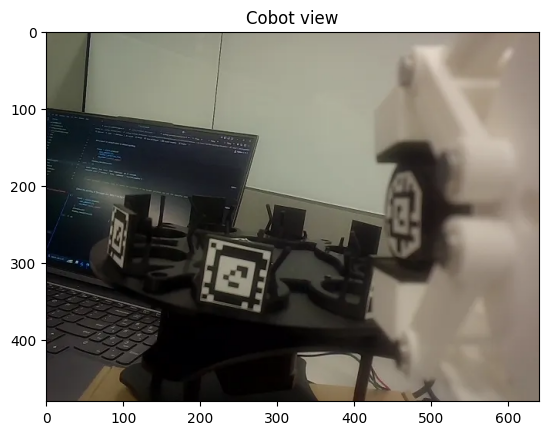

In [1383]:
result = client.predict(
	user_id=USER_ID,
	api_name="/query_camera"
)
print(result)
display_result(result)


In [ ]:

image_path = result[1]["value"]

import numpy as np

camera_params = np.load("camera_params.npy", allow_pickle=True).item()

detections = detect_apriltags(
    image_path,
    camera_matrix=camera_params['camera_matrix'],
    dist_coeffs=camera_params['dist_coeff'],
    tag_size_meters=0.013,
    families="tagStandard52h13",
    only_ID=False
)

det = min(detections, key=lambda d: np.linalg.norm(d.pose_t))

pose_t = det.pose_t.flatten()        
pose_R = det.pose_R                   

GRIPPER_TOTAL_OFFSET = np.array([0.0, 20.0, -79.0])  # in mm

offset_in_world = pose_R @ (GRIPPER_TOTAL_OFFSET / 1000.0) 
pose_t_corrected = pose_t + offset_in_world              
pose_t_corrected_mm = pose_t_corrected * 1000         

rx1, ry1, rz1 = R.from_matrix(pose_R).as_euler('xyz', degrees=False)  

x1, y1, z1 = pose_t_corrected_mm

print("Corrected position for gripper (mm):", pose_t_corrected_mm)
print("Euler angles (radians):", rx1, ry1, rz1)
print("Tag Z axis in camera frame:", pose_R[:, 2])

Found 2 tags

Tag ID: 1
  Center: [215.57208914  93.90780417]
  Corners: [[201.61781311  86.42887878]
 [191.09898376  97.3575058 ]
 [230.34712219 101.82662201]
 [238.39294434  90.69100189]]
  Translation (x, y, z): [-0.03627912 -0.0474798   0.17019414]
  Distance from camera: 18.04 centimeters
  Roll: 0.14°, Pitch: 58.08°, Yaw: 96.69°

Tag ID: 2
  Center: [162.49249983 245.34646659]
  Corners: [[145.18690491 218.93887329]
 [135.59228516 263.80953979]
 [180.24153137 272.4307251 ]
 [189.80351257 226.60144043]]
  Translation (x, y, z): [-0.04483239  0.00332971  0.14065027]
  Distance from camera: 14.77 centimeters
  Roll: 3.52°, Pitch: 4.97°, Yaw: 100.38°
Corrected position for gripper (mm): [-68.02013886  -7.75963569  63.31751296]
Euler angles (radians): 0.061349501635580984 0.08682453779182309 1.7519084965065614
Tag Z axis in camera frame: [0.04471809 0.09618027 0.99435891]


Query coordinate result from the cobot, then compute object pose in the robot base frame using end-effector pose, AprilTag detection, and hand-eye calibration.

In [1385]:
result = client.predict(
    user_id=USER_ID,
    api_name="/query_coords"
)
display_result(result)

queue status: Your turn! Time remaining: 46.57 seconds.
response json: {'success': True, 'coords': [18.9, 168.8, 195.7, -90.9, -6.23, -55.44], 'command': 'query/coords'}


In [ ]:

import json
import numpy as np

result_json = json.loads(result[0])
coords = result_json["coords"]  
x, y, z, rx, ry, rz = coords

rx_rad = np.radians(rx)
ry_rad = np.radians(ry)
rz_rad = np.radians(rz)

result_pose = convert(
    x, y, z,               
    rx_rad, ry_rad, rz_rad,  
    x1, y1, z1,               
    rx1, ry1, rz1           
)

position, rx_base, ry_base, rz_base = result_pose

print("Target pose in robot base frame:")
print("Position:", position)
print("Rotation (Euler angles in rad):", rx_base, ry_base, rz_base)

Target pose in robot base frame:
Position: [ 32.36374191 261.07325845 195.04264597]
Rotation (Euler angles in rad): 2.586521249876541 1.4454195432999786 3.129233262877157
Robot coords (mm, deg): [18.9, 168.8, 195.7, -90.9, -6.23, -55.44]
AprilTag pose (mm, corrected): [-68.02013886451816, -7.759635694061, 63.31751296209657]
AprilTag euler angles (rad): 0.061349501635580984 0.08682453779182309 1.7519084965065614
Result in base frame: (array([ 32.36374191, 261.07325845, 195.04264597]), 2.586521249876541, 1.4454195432999786, 3.129233262877157)


Move down to place the vial

In [ ]:
x, y, z = position

z += 70

above_pose = ((x, y, z), rx_base, ry_base, rz_base)
move_to_pose(above_pose)


Sending coords (mm, deg): 32.36 261.07 265.04 148.2 82.82 179.29
queue status: Your turn! Time remaining: 34.17 seconds.
response json: {'success': True, 'command': 'control/coords'}


In [ ]:
x, y, z = position

z += 20

above_pose = ((x, y, z), rx_base, ry_base, rz_base)
move_to_pose(above_pose)

Sending coords (mm, deg): 32.36 261.07 215.04 148.2 82.82 179.29
queue status: Your turn! Time remaining: 28.94 seconds.
response json: {'success': True, 'command': 'control/coords'}


Open gripper

In [1391]:
result = client.predict(
	user_id=USER_ID,
	gripper_value = 90,
	movement_speed = 100,
	api_name="/control_gripper"
)
display_result(result)

queue status: Your turn! Time remaining: 24.51 seconds.
response json: {'success': True, 'command': 'control/gripper'}


Finally, move the cobot to the home palce

In [ ]:
x, y, z = position

z += 20

above_pose = ((x, y, z), rx_base, ry_base, rz_base)
move_to_pose(above_pose)

result = client.predict(
    user_id=USER_ID,
    **DEFAULT_DETECTION_POSE, 
    api_name="/control_angles"
)
display_result(result)

result = client.predict(
    user_id=USER_ID,
    **INITIAL_HOME_POSE, 
    api_name="/control_angles"
)
display_result(result)

queue status: Your turn! Time remaining: 1.44 seconds.
response json: {'success': True, 'command': 'control/angles'}
queue status: Your turn! Time remaining: 0.31 seconds.
response json: {'success': True, 'command': 'control/angles'}
